<a href="https://colab.research.google.com/github/alpacfer/carrie_vision/blob/main/notebooks/test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install dependencies

In [62]:
!pip -q install opencv-python-headless numpy matplotlib


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

print("OpenCV version:", cv2.__version__)

OpenCV version: 4.13.0


Project paths

In [64]:
from pathlib import Path
import os

env_root = os.environ.get("PROJECT_ROOT")
if env_root:
    PROJECT_ROOT = Path(env_root)
else:
    cwd = Path.cwd()
    PROJECT_ROOT = None
    for p in [cwd, *cwd.parents]:
        if (p / ".git").exists() or (p / "data" / "raw").exists():
            PROJECT_ROOT = p
            break
    if PROJECT_ROOT is None:
        PROJECT_ROOT = cwd

DATA_RAW = PROJECT_ROOT / "data" / "raw"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("PROJECT_ROOT exists:", PROJECT_ROOT.exists())
print("DATA_RAW exists:", DATA_RAW.exists())
print("Images found:", list(DATA_RAW.iterdir()) if DATA_RAW.exists() else [])


PROJECT_ROOT: c:\Users\User\Documents\GitHub\carrie_vision
PROJECT_ROOT exists: True
DATA_RAW exists: True
Images found: [WindowsPath('c:/Users/User/Documents/GitHub/carrie_vision/data/raw/PXL_20260209_120141787.jpg'), WindowsPath('c:/Users/User/Documents/GitHub/carrie_vision/data/raw/PXL_20260209_120146305.jpg'), WindowsPath('c:/Users/User/Documents/GitHub/carrie_vision/data/raw/PXL_20260209_120201736.jpg'), WindowsPath('c:/Users/User/Documents/GitHub/carrie_vision/data/raw/PXL_20260209_120211408.jpg'), WindowsPath('c:/Users/User/Documents/GitHub/carrie_vision/data/raw/PXL_20260209_120240942.jpg'), WindowsPath('c:/Users/User/Documents/GitHub/carrie_vision/data/raw/PXL_20260209_120242538.MACRO_FOCUS.jpg'), WindowsPath('c:/Users/User/Documents/GitHub/carrie_vision/data/raw/PXL_20260209_120249190.jpg'), WindowsPath('c:/Users/User/Documents/GitHub/carrie_vision/data/raw/PXL_20260209_120310559.jpg'), WindowsPath('c:/Users/User/Documents/GitHub/carrie_vision/data/raw/PXL_20260209_120341001.

In [65]:
IMAGE_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

if not DATA_RAW.exists():
    raise RuntimeError(
        f"DATA_RAW does not exist: {DATA_RAW}. "
        "Set PROJECT_ROOT or open the repo root in VS Code."
    )

image_paths = sorted(
    p for p in DATA_RAW.iterdir()
    if p.suffix.lower() in IMAGE_EXTS
)

print("Found images:", len(image_paths))
for p in image_paths[:5]:
    print("-", p.name)

def imread_bgr(path: Path):
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        raise RuntimeError(f"Failed to read image: {path}")
    return img


Found images: 14
- PXL_20260209_120141787.jpg
- PXL_20260209_120146305.jpg
- PXL_20260209_120201736.jpg
- PXL_20260209_120211408.jpg
- PXL_20260209_120240942.jpg


# Helper functions

In [66]:
def show_bgr(img, title=None):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    if title:
        plt.title(title)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

In [67]:
import math
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image_grid(
    items,
    cols=4,
    max_images=None,
    max_size=300,
    titles=True,
    extra_texts=None
):
    """
    Display images in a grid.

    items can be:
    - list of paths (Path/str)
    - list of images (np.ndarray, BGR)
    - a mix of both

    extra_texts:
    - optional list of strings aligned to items, appended to title
    """
    items = list(items)
    if max_images is not None:
        items = items[:max_images]
    if extra_texts is not None:
        extra_texts = list(extra_texts)[:len(items)]

    n = len(items)
    if n == 0:
        raise ValueError("No images to display")

    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols * 3, rows * 3))

    for i, item in enumerate(items):
        # Load image
        if isinstance(item, np.ndarray):
            img = item
            name = f"img_{i}"
        else:
            path = Path(item)
            img = cv2.imread(str(path), cv2.IMREAD_COLOR)
            if img is None:
                raise RuntimeError(f"Failed to read image: {path}")
            name = path.name

        # Resize for display
        h, w = img.shape[:2]
        scale = min(1.0, max_size / max(h, w))
        if scale < 1.0:
            img = cv2.resize(
                img,
                (int(w * scale), int(h * scale)),
                interpolation=cv2.INTER_AREA
            )

        # BGR -> RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img_rgb)
        ax.axis("off")
        if titles:
            title = name
            if extra_texts is not None and i < len(extra_texts):
                title = f"{name} | {extra_texts[i]}"
            ax.set_title(title, fontsize=8)

    plt.tight_layout()
    plt.show()


In [68]:
from typing import Iterable, List, Optional, Tuple, Union
from pathlib import Path
import cv2
import numpy as np

# ROI format: (x, y, w, h) with x,y as top-left corner in pixels.
Roi = Tuple[int, int, int, int]
ImageOrPath = Union[np.ndarray, Path, str]

def _clip_roi_to_image(roi: Roi, w: int, h: int) -> Roi:
    x, y, rw, rh = roi
    x = max(0, x)
    y = max(0, y)
    rw = max(1, rw)
    rh = max(1, rh)

    # Clip width/height so x+rw <= w and y+rh <= h
    rw = min(rw, w - x)
    rh = min(rh, h - y)

    if rw <= 0 or rh <= 0:
        raise ValueError(f"ROI {roi} is outside image bounds (w={w}, h={h}).")

    return (x, y, rw, rh)

def _center_square_roi(img_w: int, img_h: int, side: int) -> Roi:
    side = int(side)
    if side <= 0:
        raise ValueError("side must be > 0")

    side = min(side, img_w, img_h)
    x = (img_w - side) // 2
    y = (img_h - side) // 2
    return (x, y, side, side)

def crop_images_to_roi(
    images: Iterable[ImageOrPath],
    roi: Optional[Roi] = None,
    center_square_side: int = 256,
) -> Tuple[List[np.ndarray], Roi]:
    """
    Crop a set of images to a region of interest (ROI).

    Parameters
    ----------
    images:
        Iterable of images (np.ndarray in BGR) OR file paths (str/Path).
    roi:
        Optional ROI as (x, y, w, h). If None, uses a centered square ROI.
    center_square_side:
        Side length (px) for the default centered square ROI.

    Returns
    -------
    cropped_images:
        List of cropped images (np.ndarray).
    used_roi:
        The ROI actually used (clipped if needed) in (x, y, w, h).
        Note: If images have different sizes and roi=None, ROI is computed from the first image.
    """
    images = list(images)
    if not images:
        raise ValueError("images is empty")

    # Load first image to define default ROI if needed
    first = images[0]
    if isinstance(first, (str, Path)):
        first_img = cv2.imread(str(first), cv2.IMREAD_COLOR)
        if first_img is None:
            raise RuntimeError(f"Failed to read image: {first}")
    else:
        first_img = first

    h0, w0 = first_img.shape[:2]

    if roi is None:
        roi0 = _center_square_roi(w0, h0, center_square_side)
    else:
        roi0 = roi

    # Crop all images using the ROI computed from first image,
    # clipped independently per image (in case of varying sizes).
    cropped = []
    for item in images:
        if isinstance(item, (str, Path)):
            img = cv2.imread(str(item), cv2.IMREAD_COLOR)
            if img is None:
                raise RuntimeError(f"Failed to read image: {item}")
        else:
            img = item

        h, w = img.shape[:2]
        used = _clip_roi_to_image(roi0, w=w, h=h)
        x, y, rw, rh = used
        cropped.append(img[y:y+rh, x:x+rw].copy())

    return cropped, roi0


In [69]:
from typing import Iterable, List, Optional, Tuple, Union
from pathlib import Path
import cv2
import numpy as np

Circle = Tuple[int, int, int]  # (x, y, r)
ImageOrPath = Union[np.ndarray, str, Path]

def _load_bgr(item: ImageOrPath) -> np.ndarray:
    if isinstance(item, np.ndarray):
        return item
    img = cv2.imread(str(item), cv2.IMREAD_COLOR)
    if img is None:
        raise RuntimeError(f"Failed to read image: {item}")
    return img

def detect_circles_hough_batch(
    images: Iterable[ImageOrPath],
    min_radius: int,
    max_radius: int,
    dp: float = 1.2,
    min_dist: Optional[float] = None,
    param1: float = 120.0,
    param2: float = 35.0,
    blur_ksize: int = 9,
    blur_sigma: float = 2.0,
) -> List[List[Circle]]:
    """
    Detect circles in each image using cv2.HoughCircles.

    Parameters
    ----------
    images:
        Iterable of images (BGR np.ndarray) or image paths.
    min_radius, max_radius:
        Radius range in pixels (inclusive-ish, as per OpenCV).
    dp:
        Inverse ratio of the accumulator resolution to the image resolution.
    min_dist:
        Minimum distance between detected circle centers. If None, defaults to min_radius.
    param1:
        Higher threshold for the internal Canny edge detector.
    param2:
        Accumulator threshold for circle detection. Higher => fewer detections.
    blur_ksize, blur_sigma:
        Gaussian blur settings to reduce noise.

    Returns
    -------
    all_detections:
        List of length N_images.
        Each entry is a list of circles: [(x, y, r), ...]
        If no circles found, that entry is [].
    """
    if min_radius <= 0 or max_radius <= 0:
        raise ValueError("min_radius and max_radius must be > 0")
    if max_radius < min_radius:
        raise ValueError("max_radius must be >= min_radius")

    images = list(images)
    if not images:
        return []

    if min_dist is None:
        min_dist = float(min_radius)

    results: List[List[Circle]] = []

    for item in images:
        img_bgr = _load_bgr(item)
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        # Gaussian blur to suppress noise
        k = int(blur_ksize)
        if k % 2 == 0:
            k += 1  # must be odd
        gray_blur = cv2.GaussianBlur(gray, (k, k), blur_sigma)

        circles = cv2.HoughCircles(
            gray_blur,
            cv2.HOUGH_GRADIENT,
            dp=dp,
            minDist=min_dist,
            param1=param1,
            param2=param2,
            minRadius=int(min_radius),
            maxRadius=int(max_radius),
        )

        if circles is None:
            results.append([])
            continue

        circles = np.round(circles[0]).astype(int)  # shape: (K, 3)
        detections = [(int(x), int(y), int(r)) for x, y, r in circles]
        results.append(detections)

    return results


In [70]:
from typing import Iterable, List, Tuple, Union
from pathlib import Path
import cv2
import numpy as np

Circle = Tuple[int, int, int]   # (x, y, r)
ImageOrPath = Union[np.ndarray, str, Path]

def visualize_all_circles(
    images: Iterable[ImageOrPath],
    all_circles: List[List[Circle]],
    circle_color=(255, 0, 0),   # BGR
    center_color=(0, 0, 255),   # BGR
    thickness: int = 2,
    center_radius: int = 2,
) -> List[np.ndarray]:
    """
    Draw all detected circles on all images.

    Parameters
    ----------
    images:
        Iterable of images (np.ndarray, BGR) or paths.
    all_circles:
        List of detections per image. Must align with images order.
    circle_color:
        BGR color for circle outline.
    center_color:
        BGR color for center dot.
    thickness:
        Circle outline thickness in pixels.
    center_radius:
        Radius of the center dot.

    Returns
    -------
    visualized_images:
        List of images with circles drawn.
    """
    images = list(images)
    if len(images) != len(all_circles):
        raise ValueError(
            f"images ({len(images)}) and all_circles ({len(all_circles)}) must have same length"
        )

    out_images: List[np.ndarray] = []

    for item, circles in zip(images, all_circles):
        # Load image if needed
        if isinstance(item, np.ndarray):
            img = item.copy()
        else:
            img = cv2.imread(str(item), cv2.IMREAD_COLOR)
            if img is None:
                raise RuntimeError(f"Failed to read image: {item}")

        for (x, y, r) in circles:
            cv2.circle(img, (x, y), r, circle_color, thickness)
            cv2.circle(img, (x, y), center_radius, center_color, -1)

        out_images.append(img)

    return out_images


# Sanity check

Image shape: (3000, 4000, 3)


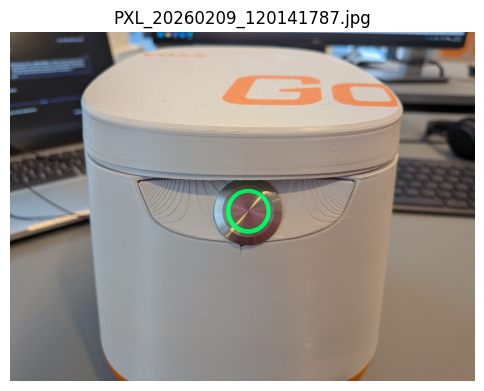

In [71]:
if not image_paths:
    raise RuntimeError("No images found in data/raw")

img = imread_bgr(image_paths[0])
print("Image shape:", img.shape)
show_bgr(img, image_paths[0].name)


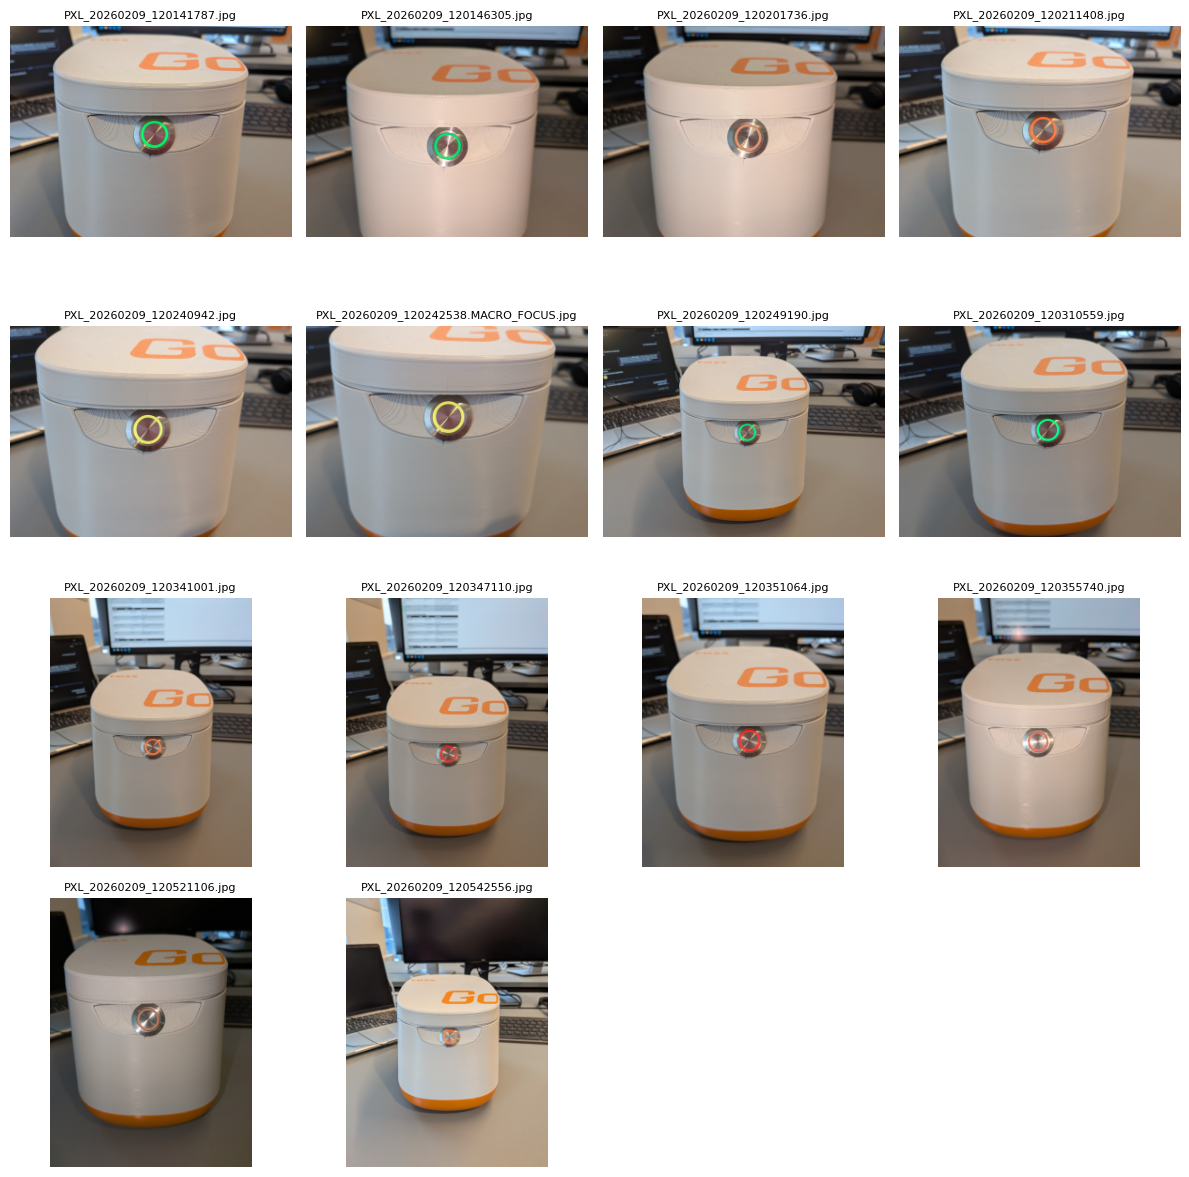

In [72]:
show_image_grid(image_paths)

# ROI

## ROI defined by a center square

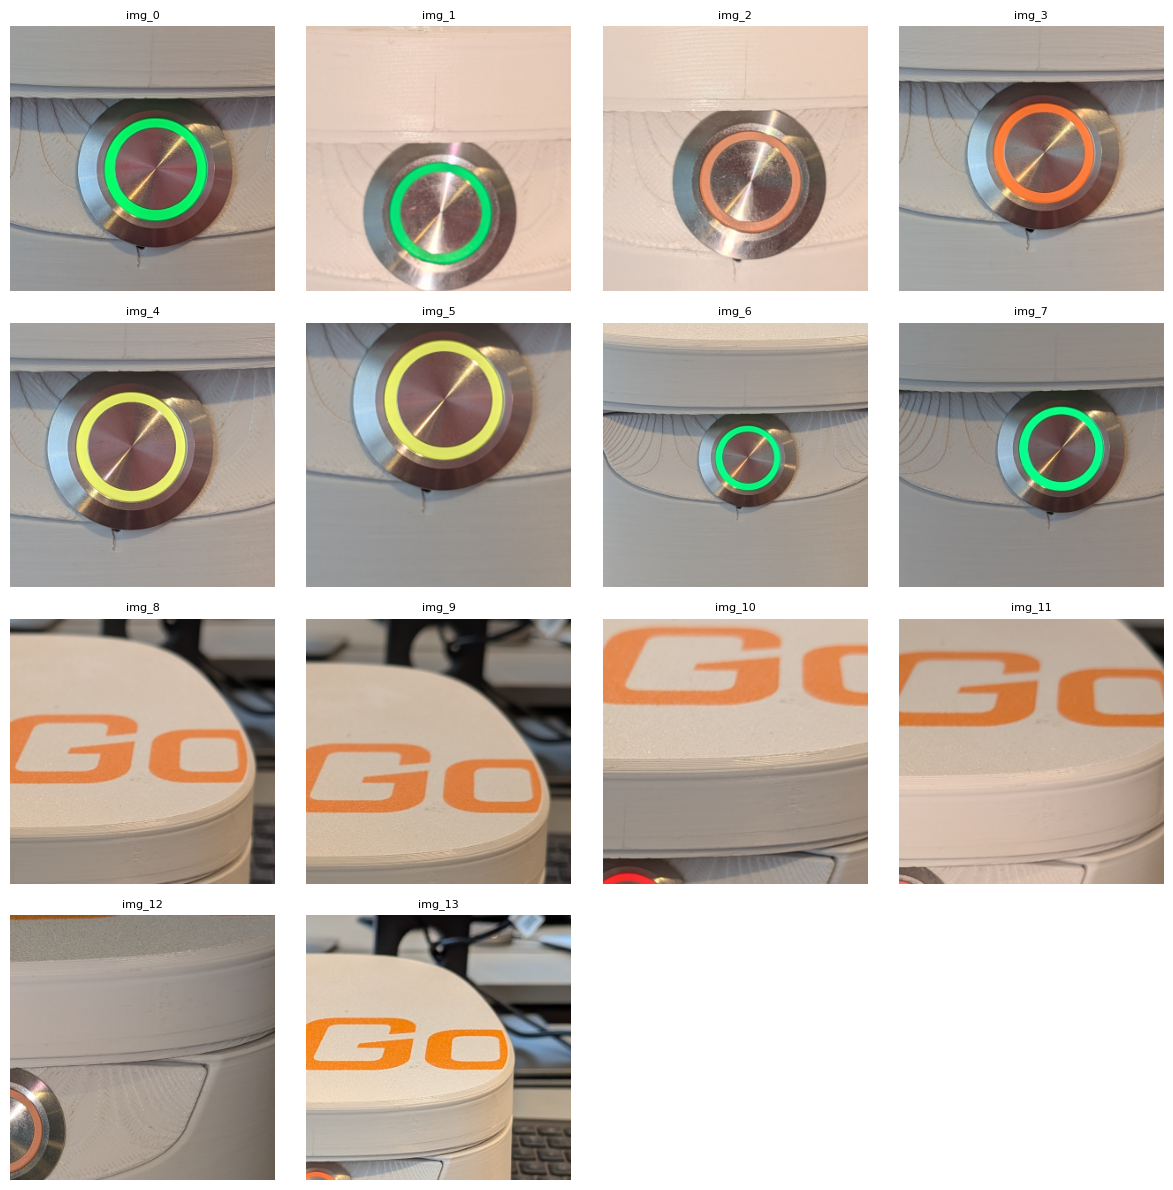

In [73]:
cropped_imgs, used_roi = crop_images_to_roi(image_paths, center_square_side=1000)
show_image_grid(cropped_imgs)

Not accurate for different angles

## ROI defined by circles

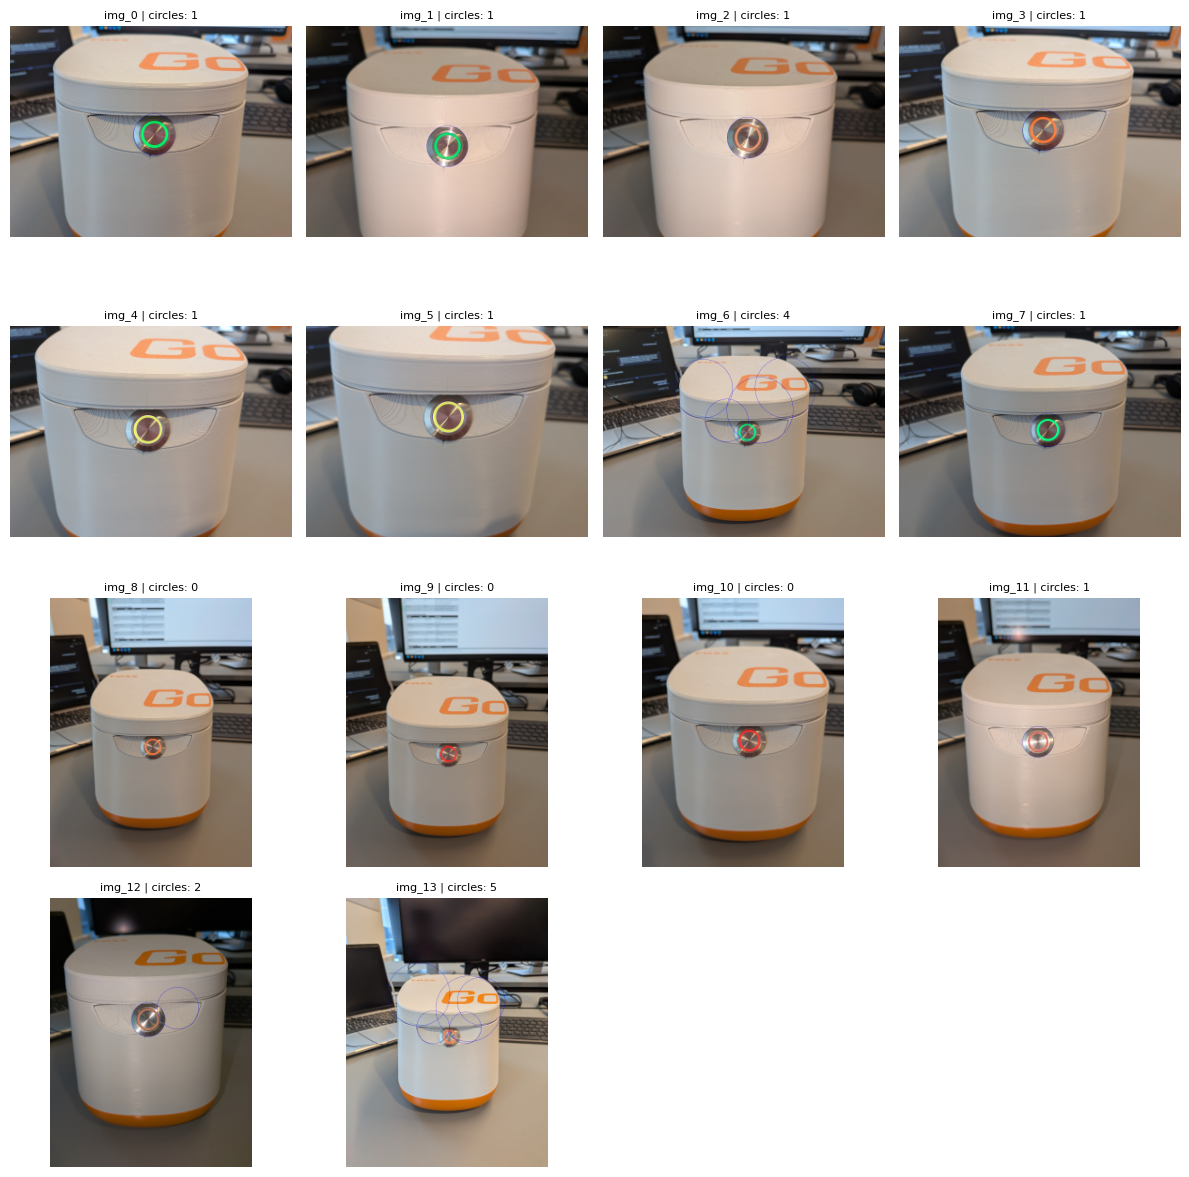

In [74]:
all_circles = detect_circles_hough_batch(
    image_paths,
    min_radius=200,
    max_radius=500
)

# Visualize
vis_imgs = visualize_all_circles(image_paths, all_circles)

# Show as grid
circle_counts = [f"circles: {len(c)}" for c in all_circles]
show_image_grid(vis_imgs, extra_texts=circle_counts)
